In [109]:
import hdnet
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt

In [110]:
Js = spio.loadmat('data/exp2/Jexp2.mat')
Js = Js['Js']
thetas = spio.loadmat('data/exp2/Theta_exp2.mat')
thetas = thetas['Thetas']

In [181]:
NEURONS=15
NUM_SAMPLES=2*10**3
BURN_IN=5*10**2

In [182]:
true_spikes = hdnet.spikes.Spikes(spikes=hdnet.sampling.sample_from_ising_gibbs(J=Js[0,:NEURONS,:NEURONS], theta=thetas[0,:NEURONS], 
num_samples = NUM_SAMPLES,burn_in=BURN_IN, sampling_steps=500))
print(true_spikes._spikes.shape)

(1, 15, 2000)


In [183]:
print(true_spikes.get_frequencies())

Counter({'000000000000000': 664, '000010000000000': 321, '000000000000010': 190, '000010000000010': 95, '100000000000000': 64, '000000000001000': 55, '001010000000010': 49, '001000000000010': 47, '000000010000000': 43, '010000000000000': 32, '100000000000010': 28, '001010000000000': 28, '100010000000000': 26, '000000000001010': 25, '000010100000000': 20, '001000000000000': 18, '010000000000010': 17, '000000010000010': 16, '000001000000000': 13, '000000100000000': 13, '000010000001000': 12, '000010010000000': 11, '000010000001010': 10, '001000100000010': 9, '000001000000010': 8, '010010000000000': 8, '100010000000010': 8, '001010100000000': 8, '001010100000010': 7, '000000000000100': 7, '010010010000000': 7, '010000010000000': 7, '001010000001000': 6, '001010000001010': 6, '010010000000010': 6, '101000000000010': 5, '010000010000010': 4, '001000100000000': 4, '000000010001010': 4, '000011000000000': 4, '100000000001000': 4, '011010000000010': 3, '000000010001000': 3, '001000010000000': 

In [184]:
# Last Neuron is constant 0
print(np.sum(true_spikes._spikes[0][14:15, :]))

0.0


In [189]:
matrix_spikes = true_spikes._spikes[0].T
print(np.shape(matrix_spikes))
print(type(matrix_spikes))
from oct2py import octave
source = "/home/shiven/Desktop/GSoC-INCF/cdme/CDMentropy"
octave.addpath(octave.genpath(source))
octave.addpath(octave.genpath(source+'/lib/PYMentropy'))
nn,ocnts=octave.words2nnOcnts(matrix_spikes,nout=2)
m = np.shape(matrix_spikes)[0]
opts = octave.struct('isDBer',True,'verbose',True,'nMC',999)
print(octave.computeH_CDM(nn, ocnts, m, opts))

(2000, 15)
<class 'numpy.ndarray'>
DBer mode: 0.000534
4.044259244975469


In [200]:
print(true_spikes._spikes[0][0:13, 10])
print(np.shape(true_spikes._spikes[0][0:13, 10]))
print(true_spikes._spikes[0][14:15, 20])
print(np.shape(true_spikes._spikes[0][14:15, 20]))
print(np.append(true_spikes._spikes[0][0:13, 10],true_spikes._spikes[0][14:15, 20]))

[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
(13,)
[0.]
(1,)
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [246]:
class CDMentropy:
    """
    Calculates entropy and corresponding mutual information for spiketrain data appended with stimulus
    """
    def __init__(self, source, spikes, isDBer=True, verbose=False, nMC=999):
        """
        Initialises oct2py interface for CDMentropy MATLAB code

        Parameters
        ----------
        source : string
            path to CDMentropy MATLAB codebase
        spikes : HDNet Spikes object
        isDBer : bool
        verbose : bool
        nMC : int
        """
        octave.addpath(octave.genpath(source))
        octave.addpath(octave.genpath(source+'/lib/PYMentropy'))
        self.opts=octave.struct('isDBer',isDBer,'verbose',verbose,'nMC',nMC)
        self.spikes=spikes

    def _entropyCDM(self,matrix_spikes):
        """
        Parameters
        ----------
        matrix_spikes : 2d array
            M*N array of spiketrain

        Returns
        -------

        """
        print(np.shape(matrix_spikes))
        nn,ocnts=octave.words2nnOcnts(matrix_spikes,nout=2)
        m = np.shape(matrix_spikes)[0]
        return octave.computeH_CDM(nn, ocnts, m, self.opts) 

    def entropyCDM(self, trial, time_start, neuron_start, time_end=None,neuron_end=None):
        """
        Returns entropy calculated upon spiketrain, specifying time bins to consider and neurons to include in calculation

        Parameters
        ----------
        trial : int
            trial number to calculate on from spikes
        time_start : int
            start of range of timebins included in calculation (included in range)
        time_end : int
            end of range of timebins included in calculation (excluded in range)
        neuron_start : int
            start of range of neurons included in calculation (included in range)
        neuron_end : int
            end of range of neurons included in calculation (excluded in range)

        Returns
        -------
        """
        if time_end is None:
            time_end=time_start+1
        if neuron_end is None:
            neuron_end=neuron_start+1
        return self._entropyCDM(self.spikes._spikes[trial][neuron_start:neuron_end,time_start:time_end].T)

    def mutualInformation(self, trial, neuron_start, neuron_end, stimulus_start, stimulus_end, time, tau):
        """
        Parameters
        ----------
        trial : int
            trial number to calculate on from spikes
        neuron_start : int
            start of range of neurons included in calculation (included in range)
        neuron_end : int
            end of range of neurons included in calculation (excluded in range)
        stimulus_start : int
            start of range of neurons in spikes denoting binary stimulus (included in range)
        stimulus_end : int
            end of range of neurons in spikes denoting binary stimulus (excluded in range)
        time : int
            timestep for which neuron spikes considered
        tau : int
            shift in time from which stimulus considered

        Returns
        -------
        """
        HX_t = self._entropyCDM(self.spikes._spikes[trial][neuron_start:neuron_end, time:time+1])
        HR_t_tau = self._entropyCDM(self.spikes._spikes[trial][stimulus_start:stimulus_end, time+tau:time+tau+1])
        H_R_t_tau_X_t = self._entropyCDM(np.atleast_2d(np.append(self.spikes._spikes[trial][neuron_start:neuron_end, time:time+1], 
        self.spikes._spikes[trial][stimulus_start:stimulus_end, time+tau:time+tau+1])).T)
        return HX_t+HR_t_tau-H_R_t_tau_X_t 

    def mutualInformationWindowed(self, trial, neuron_time_start, neuron_start, stimulus_start, stimulus_time_start, neuron_time_end=None, 
    neuron_end=None, stimulus_end=None, stimulus_time_end=None):
        """
        WIP

        Returns mutualInformation between neuron responses and stimulus appended to spikes for timebins in a range using CDM Entropy

        Parameters
        ----------
        trial : int
            trial number to calculate on from spikes
        neuron_time_start : int
            start of range of timebins included in calculation (included in range)
        neuron_time_end : int
            end of range of timebins included in calculation (excluded in range)
        neuron_start : int
            start of range of neurons included in calculation (included in range)
        neuron_end : int
            end of range of neurons included in calculation (excluded in range)
        stimulus_start : int
            start of range of neurons in spikes denoting binary stimulus (included in range)
        stimulus_end : int
            end of range of neurons in spikes denoting binary stimulus (excluded in range)
        stimulus_time_start : int
        stimulus_time_end : int

        Returns
        -------
        """
        if stimulus_end is None:
            stimulus_end = np.shape(self.spikes._spikes[trial])[0]
        HR = self._entropyCDM(self.spikes._spikes[trial][neuron_start:neuron_end,neuron_time_start:neuron_time_end])
        HX = self._entropyCDM(self.spikes._spikes[trial][stimulus_start:stimulus_end,stimulus_time_start:stimulus_time_end])
        temp_concat_spikes = np.atleast_2d(np.append(self.spikes._spikes[trial][neuron_start:neuron_end, neuron_time_start:neuron_time_end], 
        self.spikes._spikes[trial][stimulus_start:stimulus_end, stimulus_time_start:stimulus_time_end])).T
        HRX = self._entropyCDM(temp_concat_spikes)
        return HR+HX-HRX

In [247]:
cdme = CDMentropy(source='/home/shiven/Desktop/GSoC-INCF/cdme/CDMentropy', spikes=true_spikes)

Htot = cdme.entropyCDM(trial = 0, time_start = 0, neuron_start = 0, time_end = NUM_SAMPLES, neuron_end = NEURONS)
print("H total",Htot)

Hr = cdme.entropyCDM(trial = 0, time_start = 0, neuron_start = 14, time_end = NUM_SAMPLES, neuron_end = NEURONS)
print("H stimulus",Hr)

Hx = cdme.entropyCDM(trial = 0, time_start = 0, neuron_start = 0, time_end = NUM_SAMPLES, neuron_end = 13)
print("H neuron", Hx)

print("first 2 MI", Hr+Hx)

I_hack = cdme.mutualInformation(trial = 0, neuron_start = 0, neuron_end = 13, stimulus_start= 14, stimulus_end= 15, time = 10, tau = 20)
print("MI, one time", I_hack)

I = cdme.mutualInformationWindowed(trial = 0, neuron_time_start = 10, neuron_start = 0, stimulus_start = 14, stimulus_time_start = 30, 
neuron_time_end = 11, neuron_end = 13, stimulus_end = 15, stimulus_time_end=31)
print("MI",I)

(2000, 15)
H total 4.044259244975469
(2000, 1)
H stimulus 0.0
(2000, 13)
H neuron 3.235971203986079
first 2 MI 3.235971203986079
(13, 1)
(1, 1)
(14, 1)
MI, one time 0.039810471871732145
(13, 1)
(1, 1)
(14, 1)
MI 0.039810471871732145


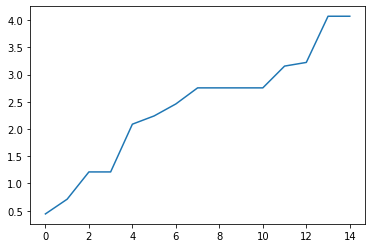

In [107]:
y=[]
x=[]
for i in range(NEURONS):
    y.append(cdme.entropy_CDM(true_spikes,0,neuron_start=0,neuron_end=i+1))
    x.append(i)
plt.plot(x,y)
# print(x)
# print(s)

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:00<00:02,  7.87it/s]

 15%|█▌        | 3/20 [00:00<00:02,  7.57it/s]

 20%|██        | 4/20 [00:00<00:02,  7.23it/s]

 25%|██▌       | 5/20 [00:00<00:02,  6.73it/s]

 30%|███       | 6/20 [00:00<00:02,  6.21it/s]

 35%|███▌      | 7/20 [00:01<00:02,  6.19it/s]

 40%|████      | 8/20 [00:01<00:02,  5.80it/s]

 45%|████▌     | 9/20 [00:01<00:02,  5.40it/s]

 50%|█████     | 10/20 [00:01<00:01,  5.46it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  5.25it/s]

 60%|██████    | 12/20 [00:02<00:01,  5.14it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.06it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.18it/s]

 75%|███████▌  | 15/20 [00:02<00:01,  4.89it/s]

 80%|████████  | 16/20 [00:02<00:00,  4.51it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  4.60it/s]

 90%|█████████ | 18/20 [00:03<00:00,  3.82it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  3.99it/s]

100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


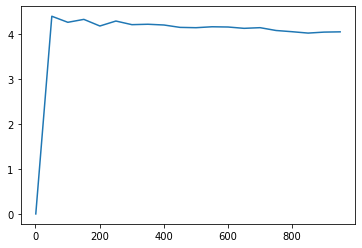

In [108]:
x=[]
y=[]
from tqdm import tqdm
for i in tqdm(range(1,NUM_SAMPLES,50)):
    x.append(i)
    y.append(cdme.entropy_CDM(true_spikes,0,0,i))
plt.plot(x,y)